# Create Dataset by WebScraping

**Creat At**: 27/04/2022
**Update At: **: 06/05/2022

**Objetivo**
+ Acessar 3 sites com `request, BeautifulSoup` e fazer WebScraping para:
  - [x] Site do TSE: Tem o gasto de campanha
  - [x] Site da GazetaDoPovo: Tem informações pessoais, votos e onde conseguiu votos
  - [x] Site do Estadão: Tem os bensDeclarados

# Import

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os 


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

# Snippets

In [5]:
def convert_long_comment_in_string(long_txt):
    """
    Converter uma lista grande dos attrs que queremos filtrar, pois selecionei manualmente
    """
    return list(map(lambda x: x.strip(), long_txt.split('\n')[1:-1] ))

In [6]:
def filter_dict_deep_by_keys(adict, list_keys):
    """
    Goal: Filter some Keys of dict even his keys is a sub.key
    BR: Filtrar seomente alguns atributos do JSON, mesmo que seja um Objeto dentro de outro
    Baseado em: https://thispointer.com/python-filter-a-dictionary-by-conditions-on-keys-or-values/
    @list_keys vem dea funcao : 'convert_long_comment_in_string'
    """
    newDict = dict()
    for (key, value) in adict.items():
        if key in list_keys:
            newDict[key] = value
    return newDict            

In [5]:
def request_get(url, lib_parser = 'html.parser'):
    """
    lib_paeser : 'html.parser' // 
    return BeautifulSoupPage
    """
    response = requests.get(url)
    if(response.status_code != 200):
        print(url, 'Erro Code')
        quit()
    return BeautifulSoup(response.text, lib_parser)

In [40]:
def to_df_from_list_of_objs_sorted(list_of_obj):
    """
        Converte de:
    [{'id': 5, 'nome': 'rafael'},  {'id': 6, 'nome': 'marta'}]
        Para DataFrame
    OBS: Esse processo é mais complxo pois tem que ser feito
    """
    variables = list_of_obj[0].keys()

    def aux_obj_to_list_sorted(obj, features):
        alist = []
        for feat in features:
            alist.append(obj[feat])
        return alist

    return pd.DataFrame(
                list( map( lambda x: aux_obj_to_list_sorted(x, variables), list_of_obj)),
                columns = variables)

# TSE - Get All data from Deputados Estaduais

In [49]:
urls = {
'all': 'https://divulgacandcontas.tse.jus.br/divulga/rest/v1/candidatura/listar/2018/BA/2022802018/7/candidatos',
# 'tse1': 'https://divulgacandcontas.tse.jus.br/divulga/rest/v1/candidatura/buscar/2018/BA/2022802018/candidato/%%',
    'tse': 'https://divulgacandcontas.tse.jus.br/divulga/rest/v1/prestador/consulta/2022802018/2018/BA/7/XXZXX/NN/%%'
#     'https://divulgacandcontas.tse.jus.br/divulga/rest/v1/prestador/consulta/2022802018/2018/BA/7/65/65456/50000603943'
# 'tse2': 'https://divulgacandcontas.tse.jus.br/divulga/rest/v1/prestador/consulta/2022802018/2018/BA/7/NN/XXZXX/%%'
}

In [50]:
list_governador_keys_tse1 = """
    idCandidato
    nrPartido
    nomePartido
    siglaPartido
    despesas
    dadosConsolidados
"""

# Lista dos atributos a serem filtrados do JON, pois o JSON é muito grande
# Escolhidos arbitrariamente de acordco com a proposta
l1 = convert_long_comment_in_string(list_governador_keys_tse1) 

In [51]:
# first api call to get list aof all deputados estaduais
# precisamos de 3 valores para fazer replace na base das 2 urls de TSE para cada candidato
tse_all = requests.get(urls['all']).json()

In [52]:
deputados_estaduais_tse = []
# count = 1

for el in tse_all['candidatos']:
    
    number_full = str(el['numero'])[:2]
    print(el['id'], el['nomeUrna'], el['numero'], number_full)
    # Out: 50000606390 ABRAAO JOVINIANO 31168 31
    
    ######## replaces in URLs ########
    el_url_tse = urls['tse'].replace('%%', str(el['id'])).replace(
        'NN', str(el['numero'])).replace('XXZXX', number_full)
#     el_url_tse_2 = urls['tse2'].replace('%%', str(el['id'])).replace(
#         'NN', str(el['numero'])).replace('XXZXX', number_full)
    
    ######## request json ########
    tse = requests.get(el_url_tse).json()
#     tse2 = requests.get(el_url_tse_2).json()
    
    ######## filter attrs ########
    tse_re = filter_dict_deep_by_keys(tse, l1)
#     tse2_re = filter_dict_deep_by_keys(tse2, l2)
    
    ######## pre-processing data TSE2 ########
    # Por todos os attrs de despesas pra fora
    list_despesas = ['totalDespesasContratadas', 'totalDespesasPagas']
#     print(tse_re.get('despesas'))
    if(tse_re.get('despesas') is not None):
        for el_list in list_despesas:
            tse_re[el_list] = tse_re['despesas'][el_list]
    else:
        for el_list in list_despesas:
            tse_re[el_list] = None
    tse_re.pop('despesas', None)
            
    # word_freq.get(key) is not None:
    list_dadosConsolidados = ['totalRecebido', 'totalFinanceiro']
    if(tse_re.get('dadosConsolidados') is not None):
        for el_list in list_dadosConsolidados:
            tse_re[el_list] = tse_re['dadosConsolidados'][el_list]
    else:
        for el_list in list_dadosConsolidados:
            tse_re[el_list] = None
    tse_re.pop('dadosConsolidados', None)
    # Por todos os attrs de dadosConsolidados pra fora
#     if(tse2_re['dadosConsolidados'] is not None):
#         for el in list(tse2_re['dadosConsolidados'].keys()):
#             tse2_re[el] = tse2_re['dadosConsolidados'][el]
#     else:
#         tse2_re['dadosConsolidados'] = None
#     tse2_re.pop('despesas', None)
#     tse2_re.pop('dadosConsolidados', None)
    ######## Join ########
    tse_basic = { 'idIBGE': el['id'], 'nrCandidato': el['numero']}
    tse_final = { **tse_re,  **tse_basic } # **tse2_re,
#     print(tse_final)
#     break
#     count += 1
#     if(count == 3):
#         break
    deputados_estaduais_tse.append(tse_final)
    

50000606390 ABRAAO JOVINIANO 31168 31
50000608091 ADEMAR SIMÕES 15153 15
50000605231 ADERBAL CALDAS 11111 11
50000607719 ADILSON CERQUEIRA 51605 51
50000605154 ADILSON DA SILVA 20222 20
50000605136 ADMILSOM CARECA 20020 20
50000607996 ADOLFO MENEZES 55111 55
50000608128 ADRIANA NEVES 27003 27
50000628475 ADRIANO CADEIRA 28999 28
50000624164 ADRIANO CADEIRA 28666 28
50000620473 ADRIANO DA CHAPADA 77888 77
50000603950 AGEU COZINHEIRO 65145 65
50000608588 AGNALDO DIAS 10999 10
50000600861 AGNALDO JOSE 50750 50
50000600929 AILTON SANTIAGO 50507 50
50000603942 ALADILCE 65654 65
50000607997 ALAN CASTRO 55700 55
50000608559 ALAN SANCHES 25700 25
50000629055 ALBA DA SAÚDE 18996 18
50000600923 ALCIDES 50550 50
50000607722 ALDY 51001 51
50000605140 ALEMÃO 20077 20
50000627544 ALENCAR 15123 15
50000608560 ALEXANDRE ALELUIA 25100 25
50000607998 ALEX DA PIATÃ 55000 55
50000608044 ALEX LIMA 40123 40
50000628737 ALFINA NINHA 65486 65
50000600931 ALFREDO BOA SORTE 50600 50
50000600899 ALICE SANT"ANA 5

50000627534 GILSON DA GS2 27222 27
50000607993 GILVÂNIA VIANA 13800 13
50000600897 GISLANE BRANDAO 50333 50
50000622624 GLEIDIMARCIA 36888 36
50000620492 GORDINHO 77445 77
50000605147 GRAÇA SANTANA 20580 20
50000608098 HAMILTON POMBAL 15000 15
50000622625 HELDER PATRIARCA 36773 36
50000605156 HILDECIO MEIRELES 20000 20
50000600927 HILTON COELHO 50150 50
50000622626 HIRÂNIA ROCHA 36050 36
50000607734 HOSANA BRASIL 51700 51
50000620480 IASMIN REIS 77077 77
50000603937 ICO DO SINDICATO 65130 65
50000622627 IDELANDIO VIEIRA 36774 36
50000609082 IDEVAL KLEBER 17777 17
50000606424 INDIO DA BAHIA 31999 31
50000625296 IRACEMA SILVA 28222 28
50000605138 IRMÃ CÂNDIDA 20139 20
50000622670 IRMA JACIARA 36044 36
50000620483 IRMÃ NEUSA 77727 77
50000629051 IRMÃO GONÇALVES 51300 51
50000625425 IRMÃO JAIME 54111 54
50000608602 IRMÃO MANOEL ALMEIDA 10500 10
50000605149 IRMÃO NERY VENDEDOR 20066 20
50000625401 IRMÃO NIEL 54170 54
50000605153 IRMÃ YVONE 20337 20
50000625424 ISAAC DE BELCHIOR 54444 54
500

50000608585 PEDRO TAVARES 25000 25
50000607755 PEDRO VAILANT 51456 51
50000606394 PELÉ DO CHUMBO 31345 31
50000606399 PERLLA LACERDA 31888 31
50000607720 PR. AGNALDO 51888 51
50000629054 PRISCILA OLIVEIRA 51200 51
50000605162 PR. LUCAS FERREIRA 20888 20
50000608095 PROF. ELISIO BRASILEIRO  15679 15
50000605241 PROFESSORA ANGÉLICA 11333 11
50000603951 PROFESSORA ANINHA 65999 65
50000607758 PROFESSORA RITA TANAJURA 51202 51
50000628930 PROFESSOR BARUELL 43444 43
50000627537 PROFESSOR EDNALDO 27533 27
50000606384 PROFESSOR EPAMINONDAS 31123 31
50000600882 PROFESSOR EUVALDO 50500 50
50000609063 PROFESSOR FÁBIO 17111 17
50000619093 PROFESSOR HIPOLITO 50245 50
50000603931 PROFESSOR JAYRO MIRANDA 65213 65
50000603947 PROFESSOR JEHORVAN 65165 65
50000629061 PROFESSOR NILO ROSA 18885 18
50000622667 PROFESSOR RATTON 36212 36
50000603928 PROFESSOR RUI 65678 65
50000608568 PROF. EUTÔNIO SOUZA 25070 25
50000600903 PROF. GILVA 50322 50
50000600868 PROF. LUCIANO BORBA 50700 50
50000600880 PROF. MAX 5

In [53]:
df_deputados_estaduais = to_df_from_list_of_objs_sorted(deputados_estaduais_tse)
df_deputados_estaduais.head()

,nrPartido,nomePartido,siglaPartido,idCandidato,totalDespesasContratadas,totalDespesasPagas,totalRecebido,totalFinanceiro,idIBGE,nrCandidato
0,31,Partido Humanista da Solidariedade,PHS,50000606390,NaN,NaN,NaN,NaN,50000606390,31168
1,15,Movimento Democrático Brasileiro,MDB,50000608091,150472.79,150472.79,170500.00,150500.00,50000608091,15153
2,11,Partido Progressista,PP,50000605231,177397.18,177397.18,198968.60,177413.60,50000605231,11111
3,51,Patriota,PATRI,50000607719,0.00,0.00,1890.11,0.00,50000607719,51605
4,20,Partido Social Cristão,PSC,50000605154,0.00,0.00,2626.52,0.00,50000605154,20222


In [55]:
df_deputados_estaduais.to_csv(
    'deputado_estadual_tse.csv', index=False, sep=';')

<AxesSubplot:>

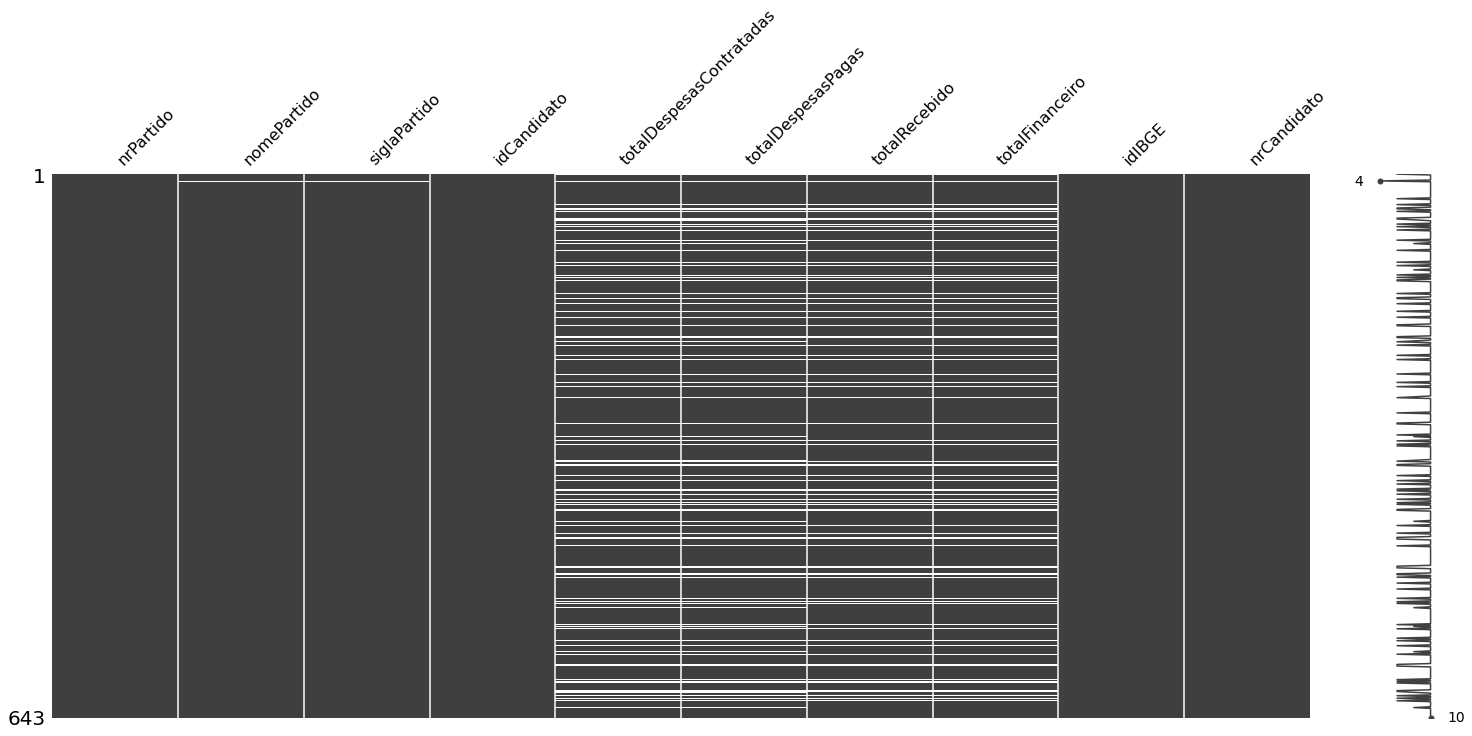

In [80]:
import missingno as msno
%matplotlib inline
msno.matrix(df_deputados_estaduais)

# Gazeta do Povo - Deputados Estaduais Info

In [9]:
deputado_info_url = 'https://especiais.gazetadopovo.com.br/eleicoes/2018/resultados/eleitos-deputado-estadual-ba-quem-ganhou/'
soup_gazeta_all_deputado = request_get(deputado_info_url)

In [15]:
list_tr = soup_gazeta_all_deputado.find('tbody').find_all('tr')
deputado_info_urls = []

for el in list_tr:
    tds = el.find_all('td')
    deputado_info_urls.append(tds[0].find('a')['href'])
    
deputado_info_urls[0]

'https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/joao-isidorio-70000/'

**RESULTADO APURAÇÃO**

````
<section class="tabela-candidato">
  <h2 class="title-uppercase bold cor-azul">Resultado da Apuração</h2>
  <p>Candidato do AVANTE, Joao Isidorio obteve 110.540 votos totalizados (1,59% dos votos válidos) e foi eleito Deputado Estadual na Bahia no 1º turno das Eleições 2018.</p>
  <table class="table">
    <tr class="situacao-candidatura eleito">
      <th>Situação:</th>
      <td>
        <span class="label label-success">Eleito</span>
      </td>
    </tr>
    <tr>
      <th>Votos:</th>
      <td>110.540 (1,59% dos válidos)</td>
    </tr>
    <tr>
      <th>Resultado Completo:</th>
      <td>
        <a href="https://especiais.gazetadopovo.com.br/eleicoes/2018/resultados/eleitos-deputado-estadual-ba-quem-ganhou/" title="Deputados estaduais eleitos na Bahia">
        Deputado Estadual na Bahia								</a>
      </td>
    </tr>
    <!--SE FOR OUTRA COISA-->
    <tr>
      <th>Resultado por cidades:</th>
      <td>
        <a href="https://especiais.gazetadopovo.com.br/eleicoes/2018/resultados/municipios-bahia/deputado-estadual-candidato-joao-isidorio-70000/">Votação de Joao Isidorio por municípios</a>
      </td>
    </tr>
  </table>
</section>
````

**BIO INFO**

In [38]:
deputado_gazeta_infos = []

for deputado_url in deputado_info_urls:
    
    print(deputado_url)
    deputado_dict = {}
    soup_page = request_get(deputado_url)
    deputado_dict['deputado_url'] = deputado_url.split('/')[-2]
    
    #### RESULTADO DA APURAÇÂO
    ###### 4 INFO: Eleito/Nao; QtdVotos; URLallDeputado (X); List url by municipios desse candidato
    sec_resultado_apuracao = soup_page.find('section', {"class": "tabela-candidato"})
    list_td = sec_resultado_apuracao.find_all('td')
    deputado_dict['eleito'] = list_td[0].get_text().replace('\n','')
    deputado_dict['votes'] = list_td[1].get_text().split(' ')[0].replace('.','')
    deputado_dict['votes%'] = list_td[1].get_text().split(' ')[1].replace(
        '\,','.').replace('(','')
    deputado_dict['votes_by_city_url'] = list_td[3].find('a')['href']
    
    #### DADOS PESSOAIS
    # sidebar-perfil
    soup = soup_page.find('div', {"class": "sidebar-perfil"})
    deputado_dict['img'] = soup.find('img')['src']
    deputado_dict['nomeCompleto'] = soup.find('h2').get_text()
    # short description
    try:
        deputado_dict['desc'] = soup.find('p', {'class':'h5'}).get_text().strip().replace(
        '\t', ' ').replace('  ',' ').replace('\n',' ').replace('  ',' ')
    except:
        deputado_dict['desc'] = ''
    # bio infos
    section_table = soup.find('table')
    section_bio_tr = section_table.find_all('tr')
    for el in section_bio_tr:
        deputado_dict[el.th.get_text().replace(':','')] = el.td.get_text() 
    
    #### DADOS DO CANDIDATO
    soup = soup_page.find_all('section', {"class": "tabela-candidato"})[1].find('table')
    trs = soup.find_all('tr')
    for el in trs:
        deputado_dict[el.th.get_text().replace(':','')] = el.td.get_text() 
    deputado_dict['Situação da candidatura'] = deputado_dict['Situação da candidatura'].split(' ')[0].replace('\n','')
    deputado_dict['Partido'] = deputado_dict['Partido'].replace('\t','').replace('\n','')
    
    deputado_gazeta_infos.append(deputado_dict)

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/joao-isidorio-70000/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/rosemberg-13444/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/diego-coronel-55255/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/ze-raimundo-13222/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/eduardo-salles-11222/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/rogerio-andrade-filho-55444/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/alex-da-piata-55000/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/alex-lima-40123/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/adolfo-menezes-55111/
https://especiais.gazetadopovo.com.br/eleicoes/2018/can

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/ze-carlos-da-cebola-22123/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/raimundinho-da-jr-12333/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/radiovaldo-13050/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/claudio-bastos-65123/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/pablo-barrozo-25678/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/luiz-carlos-suica-13031/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/rosival-leite-13333/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/hildecio-meireles-20000/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/chica-do-pt-13467/
https://especiais.gazetadopovo.com.br/ele

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/paulo-cipa-65111/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/valmir-rocha-65000/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/clovis-ferraz-55400/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/dailton-filho-70111/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jairo-araujo-65656/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/alvaro-gomes-65321/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/katia-da-saude-13666/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/alencar-15123/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/rafael-moreira-rafa-19073/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidat

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/wesley-muralha-65065/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/claudio-david-50509/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/angela-santos-50350/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/zacarias-15345/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/dr-carlos-gomes-14444/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/tuca-10595/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/gerinaldo-moreira-50013/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/ana-paula-varjao-15222/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/braguinha-10555/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/pastor-helder-20100/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/irmao-jaime-54111/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/marquinhos-pta-50777/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/regi-de-mane-51690/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/antonio-carlos-da-silva-51635/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/raimundo-alves-20658/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/tia-rai-15333/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/diomario-nascimento-25420/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/mario-nogueira-27127/
https://especiais.gazetadopovo.com.br/eleicoe

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/irma-candida-20139/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/debora-duarte-51180/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/prof-gilva-50322/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/edna-rodrigues-43184/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/schirley-pinheiro-15151/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/agnaldo-jose-50750/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/ana-monteiro-50021/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/dr-josefa-51551/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/carlos-dos-santos-barbosa-27380/
https://especiais.gazetadopovo.com.br/eleicoes/2

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/lucineide-do-jorro-51005/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/telma-pinto-14333/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/hosana-brasil-51700/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/carine-peixoto-51017/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/edmar-o-crente-10166/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/monique-elves-51204/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/socorro-27332/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/neto-metralhando-a-corrupcao-27277/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/paulo-da-grafica-20150/
https://especiais.gazetadopovo.com.br/

https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/marcio-motta-77789/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/marcos-antonio-36778/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/ninguem-36111/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/geraldo-niga-36113/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/simone-sacramento-36008/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/aristides-da-silva-29029/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/sergio-soares-36127/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/elias-de-gogo-77192/
https://especiais.gazetadopovo.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/uenio-freire-de-menezes-36689/
https://especiais.gazetadopovo.com.br/eleic

In [39]:
df_deputado_gazeta_info = to_df_from_list_of_objs_sorted(deputado_gazeta_infos)
df_deputado_gazeta_info

,deputado_url,eleito,votes,votes%,votes_by_city_url,img,nomeCompleto,desc,Nome na urna,Sexo,Idade,Data de nascimento,Ocupação,Grau de instrução,Estado Civil,Cor/Raça,Município de nascimento,Número,Situação da candidatura,Estado,Partido,Coligação,Composição
0,joao-isidorio-70000,Eleito,110540,"1,59%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Joao Paulo Santos de Santana,"Casado(a), Cantor e Compositor, nascido...",Joao Isidorio,Masculino,30 anos,26/01/1992,Cantor e Compositor,Ensino Médio completo,Casado(a),Branca,Candeias-BA,70000,Deferido,BAHIA,AVANTE - AVANTE,FORÇA DO TRABALHO PELA BAHIA,PT / PMB / PSD / PR / PDT / PODE / PRP / PP / ...
1,rosemberg-13444,Eleito,101945,"1,46%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Rosemberg Evangelista Pinto,"Divorciado(a), Deputado, nascido em 14...",Rosemberg,Masculino,66 anos,14/04/1956,Deputado,Superior completo,Divorciado(a),Branca,Itororo-BA,13444,Deferido,BAHIA,PT - Partido dos Trabalhadores,FORÇA DO TRABALHO PELA BAHIA,PT / PMB / PSD / PR / PDT / PODE / PRP / PP / ...
2,diego-coronel-55255,Eleito,100274,"1,44%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Diego Henrique Silva Cerqueira Martins,"Casado(a), Empresário, nascido em 22/0...",Diego Coronel,Masculino,39 anos,22/01/1983,Empresário,Ensino Médio completo,Casado(a),Branca,Coração de Maria-BA,55255,Deferido,BAHIA,PSD - Partido Social Democrático,FORÇA DO TRABALHO PELA BAHIA,PT / PMB / PSD / PR / PDT / PODE / PRP / PP / ...
3,ze-raimundo-13222,Eleito,94014,"1,35%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,José Raimundo Fontes,"Divorciado(a), Deputado, nascido em 15...",Zé Raimundo,Masculino,72 anos,15/04/1950,Deputado,Superior completo,Divorciado(a),Preta,Pojuca-BA,13222,Deferido,BAHIA,PT - Partido dos Trabalhadores,FORÇA DO TRABALHO PELA BAHIA,PT / PMB / PSD / PR / PDT / PODE / PRP / PP / ...
4,eduardo-salles-11222,Eleito,89123,"1,28%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Eduardo Seixas de Salles,"Divorciado(a), Deputado, nascido em 29...",Eduardo Salles,Masculino,56 anos,29/05/1965,Deputado,Superior completo,Divorciado(a),Branca,Salvador-BA,11222,Deferido,BAHIA,PP - Progressistas,FORÇA DO TRABALHO PELA BAHIA,PT / PMB / PSD / PR / PDT / PODE / PRP / PP / ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,gabriela-de-vecchi-28555,Não foi eleita,0,"0,00%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Gabriela Veiga De-Vecchi,"Solteiro(a), Jornalista e Redator, nasc...",Gabriela De-Vecchi,Feminino,40 anos,25/07/1981,Jornalista e Redator,Superior completo,Solteiro(a),Parda,Salvador-BA,28555,Indeferido,BAHIA,PRTB - Partido Renovador Trabalhista Brasileiro,RENOVA BAHIA,PHS / PPS / PRTB / PSL
603,arieli-36910,Não foi eleita,0,"0,00%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Arieli Argolo Soares,"Solteiro(a), nascida em 13/12/1984 em...",Arieli,Feminino,37 anos,13/12/1984,Outros,Ensino Médio completo,Solteiro(a),Preta,Salvador-BA,36910,Indeferido,BAHIA,PTC - Partido Trabalhista Cristão,Time do Trabalho do Povo Baiano,PTC / PMN
604,jussara-36922,Não foi eleita,0,"0,00%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Jussara Souza Santos,"Solteiro(a), nascida em 05/03/1985 em...",Jussara,Feminino,37 anos,05/03/1985,Outros,Ensino Médio completo,Solteiro(a),Branca,Salvador-BA,36922,Indeferido,BAHIA,PTC - Partido Trabalhista Cristão,Time do Trabalho do Povo Baiano,PTC / PMN
605,joabson-pereira-36150,Não foi eleito,0,"0,00%",https://especiais.gazetadopovo.com.br/eleicoes...,https://cdn-eleicoes.gazetadopovo.com.br/fotos...,Joabson Pereira

In [40]:
df_deputado_gazeta_info.to_csv(
    'deputado_gazeta_info.csv', index=False, sep=';')

# Gazeta do Povo - Votos de deputado por Cidade

In [45]:
list_votes_by_deputado = []

for index, row in df_deputado_gazeta_info.iterrows():
    
    soup_page = request_get(row['votes_by_city_url'])
    list_tr = soup_page.find('tbody').find_all('tr')
    
    for el in list_tr:
        tds = el.find_all('td')
        # constants
        deputado_votes_dict = {}
        deputado_votes_dict['deputado_url'] = row['deputado_url']
        deputado_votes_dict['deputado_nome'] = row['Nome na urna']
        deputado_votes_dict['url_vote_deputado'] = row['votes_by_city_url']
        
        # each city
        deputado_votes_dict['url_the_city_votes'] = tds[0].find('a')['href']
        deputado_votes_dict['cidade'] = tds[0].find('h2').get_text().strip()
        deputado_votes_dict['percentage'] = tds[1].find('span', {'class': 'porcentagem'}).get_text().strip()
        deputado_votes_dict['votes'] = int(tds[1].find(
            'span', {'class': 'qtd-votos'}).get_text().split(' ')[0].strip().replace('.',''))

        list_votes_by_deputado.append(deputado_votes_dict)

In [46]:
df_deputado_votos_by_city = to_df_from_list_of_objs_sorted(list_votes_by_deputado)
df_deputado_votos_by_city

,deputado_url,deputado_nome,url_vote_deputado,url_the_city_votes,cidade,percentage,votes
0,joao-isidorio-70000,Joao Isidorio,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Candeias,"15,31%",6556
1,joao-isidorio-70000,Joao Isidorio,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Saubara,"11,27%",886
2,joao-isidorio-70000,Joao Isidorio,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,São Francisco do Conde,"8,64%",2027
3,joao-isidorio-70000,Joao Isidorio,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Camaçari,"6,50%",7476
4,joao-isidorio-70000,Joao Isidorio,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Terra Nova,"6,40%",415
...,...,...,...,...,...,...,...
253114,daniel-santos-77666,Daniel Santos,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Vera Cruz,"0,00%",0
253115,daniel-santos-77666,Daniel Santos,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Vereda,"0,00%",0
253116,daniel-santos-77666,Daniel Santos,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Wagner,"0,00%",0
253117,daniel-santos-77666,Daniel Santos,https://especiais.gazetadopovo.com.br/eleicoes...,https://especiais.gazetadopovo.com.br/eleicoes...,Wanderley,"0,00%",0


In [47]:
df_deputado_votos_by_city.to_csv(
    'deputado_votes_by_city.csv', index=False, sep=';')

# Bens Declarados - Estadão

cada tr tem td. Há muita repetiçâo de tag 'a'

````html
<div class="col-xs-12">
  <div class="row">
      
    <tr>
        
      <td class="table-nome"><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jackson,13000" title="Jackson"><i class="ico-candidato-status -suplente"></i><span class="nome-ico">Jackson</span> </a></td>
        
      <td><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jackson,13000" title="Deputado Estadual">Deputado Estadual</a></td>
      <td class="partidos">
        <a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jackson,13000">
          <div class="uppercase text-wrap">pt/13000</div>
        </a>
      </td>
      <td><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jackson,13000">BA</a></td>
      <td class="td-perfil"><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jackson,13000" class="table-link text-right uppercase" title="Perfil"><span>Perfil</span><i class="ico-arrow-right"></i></a></td>
    </tr>
      
    <tr>
      <td class="table-nome"><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jacy-costa,20199" title="Jacy Costa"><i class="ico-candidato-status -suplente"></i><span class="nome-ico">Jacy Costa</span> </a></td>
      <td><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jacy-costa,20199" title="Deputado Estadual">Deputado Estadual</a></td>
      <td class="partidos">
        <a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jacy-costa,20199">
          <div class="uppercase text-wrap">psc/20199</div>
        </a>
      </td>
      <td><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jacy-costa,20199">BA</a></td>
      <td class="td-perfil"><a href="https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/jacy-costa,20199" class="table-link text-right uppercase" title="Perfil"><span>Perfil</span><i class="ico-arrow-right"></i></a></td>
    </tr>
      
    ....
      
  </div>
</div>
````

In [22]:
url_estadao = 'https://politica.estadao.com.br/eleicoes/2018/busca-ajax?type=busca-ajax&params=%7B%22search%22%3A%22%22%2C%22descricao_cargo%22%3A%5B%22DEPUTADO%20ESTADUAL%22%5D%2C%22sigla_uf%22%3A%22ba%22%2C%22despesa_min_campanha%22%3A%22%22%2C%22despesa_max_campanha%22%3A%22%22%2C%22idade_data_eleicao_min%22%3A%22%22%2C%22idade_data_eleicao_max%22%3A%22%22%7D&index=$$'

count, list_link = 0, []

while count < 660:
    print(count, end='-')
    estadao_page = request_get(url_estadao.replace('$$',str(count)))
    count += 30
    for tr in estadao_page.find_all('tr'):
        list_link.append(tr.find('a')['href'])

print('\n\n', len(set(list_link)))

0-30-60-90-120-150-180-210-240-270-300-330-360-390-420-450-480-510-540-570-600-630-

 643


````
<li> <strong class="item-tipo" title="BENS DECLARADOS">BENS DECLARADOS</strong> <span class="item-valor"> R$ 132.057,00 <a href="#bens-declarados" class="link-default link-detalhe" title="Ver Detalhado">Ver Detalhado</a> </span> </li>
````

In [37]:
list_link[0]

'https://politica.estadao.com.br/eleicoes/2018/candidatos/ba/deputado-estadual/abraao-joviniano,31168'

In [42]:
list_data_estadao = []
for link in list_link:
    adict = {}
    soup_page = request_get(link)
    strong = soup_page.find('strong', {'title': 'BENS DECLARADOS'})
    if(strong is None):
        adict['BensDeclarados'] = 'R$ 0,00'
    else:
        adict['BensDeclarados'] = strong.parent.find('span').get_text().replace(' Ver Detalhado','').strip()
    adict['nr_candidato'] = link.split(',')[-1]
    list_data_estadao.append(adict)
    
df_end = to_df_from_list_of_objs_sorted(list_data_estadao)
df_end.head()

,BensDeclarados,nr_candidato
0,"R$ 0,00",31168
1,"R$ 1.712.624,00",15153
2,"R$ 2.141.465,00",11111
3,"R$ 103.205,00",51605
4,"R$ 0,00",20222


In [43]:
df_end.to_csv(
    'deputado_bens_estadao.csv', index=False, sep=';')